In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import multivariate_normal
from sklearn.feature_extraction.text import TfidfTransformer
%matplotlib inline

np.random.seed(189)

# Problem 1: Centering and Ridge Regression

In this problem we will return to predicting the median home value in a given Census area by extending linear regression. The data is in housing data.mat and it comes from http://lib.stat.cmu.edu/datasets/houses.zip. There are only 8 features for each data point; you can read about the features in `housing_data_source.txt`.

### 1.a You are given a training set ${(x_i, y_i)}_{i=1}^n$. Let $X$ be the design matrix (i.e. the matrix whose $i^{\text{th}}$ row is $x_i$, and let $y$ be the column vector whose $i^{\text{th}}$ entry is $y_i$. Let $1$ be a $n \times 1$ column vector of ones.

Define $\bar{x} = \dfrac {1}{n} \sum_i x_{i=1}$ and $\bar{y} = \dfrac{1}{n} \sum_{i=1} y_i$. Assume that the input data has been centered, so that $\bar{x} = 0$. 

Show that the optimizer of $J(w, w_0) = (y - Xw - w_0 1)^T (y - Xw - w_0 1) + \lambda w^T w$ is given by

$$\hat{w}_0 = \bar{y}$$

$$\hat{w} = (X^T X + \lambda 1)^{-1} X^T y$$

> **Answer:**

$$
\begin{align}
J(w, w_0) &= y^T y - y^T X w - y^T w_0 1 \\
&- w^T X^T y + w^T X^T X w + w^T X^T w_0 1 \\
&- 1^T w^T_0 y + 1^T w^T_0 X w + 1^T w^T_0 w_0 1 \\
&+ \lambda w^T w \\
\end{align}
$$

Next, take the derivative w.r.t $w_0$ and set equal to 0:

$$
\begin{align}
0 &= -y^T 1 - 1^T y + w^T X^T 1 + 1^T X w + 2 w_0 1^T 1 \\
&= -2 y^T1 + 2 w^T X^T 1 + 2 w_0 1^T 1 \\
&= -y^T1 + w^T X^T 1 + w_0 1^T 1 \\
\end{align}
$$

Since $1 = n \times 1$ column vector, $1^T 1 = n$. In addition, $\sum_{i=1} y_i = y^T 1$. This gives us:

$$
\begin{align}
0 &= - \sum_{i=1} y_i + w^T X^T 1 + w_0 n \\
\end{align}
$$

Since we've centered our data, the sum of all the rows is 0. Thus, $X^T 1 = 0$.

$$
\begin{align}
0 &= - \sum_{i=1} y_i + 0 + w_0 n \\
\sum_{i=1} y_i &= w_0 n \\
\dfrac {1}{n} \sum_{i=1} y_i &= w_0 \\
\end{align}
$$

### 1.b) Using the result from part a,
#### 1.b.i) Implement a ridge regression model with least squares. Include your code in the submission.

In [2]:
house = scipy.io.loadmat('./data/housing_data.mat')
house_train_yX = np.hstack((house['Ytrain'], house['Xtrain']))
np.random.shuffle(house_train_yX)
house_train_y = np.matrix(house_train_yX[:,0]).T
house_train_X = np.matrix(house_train_yX[:,1:])

# center X
house_train_X_mu = house_train_X.mean(axis=0)
house_train_X -= house_train_X_mu

# center validation set using training set means
house_validate_X = np.matrix(house['Xvalidate']) - house_train_X_mu
house_validate_y = np.matrix(house['Yvalidate'])

In [3]:
def ridge_least_squares(X, y, lmda):
    m, n = X.shape
    X_T = X.T
    ones = np.ones((n,1))
    w = np.linalg.inv(X_T*X + lmda*ones)*X_T*y
    return w

def rss_calc(y, y_hat):
    rss = np.sum(np.square(y-y_hat))
    return rss

def predict(X, w):
    y_hat = X*w
    return y_hat

def kfold_cv(X, y, k, lmbds):
    m, n = X.shape
    index = np.arange(m)
    k_fold_indices = np.array_split(index, k)
    k_fold_results = {}
    for l in lmbds:
        results = []
        for test_index in k_fold_indices:
            # separate test set
            test_X, test_y = X[test_index], y[test_index]
            # separate training set
            train_index = np.setdiff1d(index, test_index)
            train_X, train_y = X[train_index], y[train_index]
            # run ridge
            w = ridge_least_squares(train_X, train_y, lmda=l)
            y_hat = predict(test_X, w)
            rss = rss_calc(test_y, y_hat)
            results.append(rss)
        k_fold_results[l] = np.mean(results)
    return k_fold_results

#### 1.b.ii) Use 10-fold cross validation to tune the hyperparameter $\lambda$. Using the tuned value of $\lambda$, test your trained model on the validation set. What is the residual sum of squares (RSS) on the validation set? How does this compare to the result from HW3?


> **Answer:**

> My new RSS for the validation set is `5.547e+13` vs my HW3 RSS of `5.795e+12`. This Ridge RSS was greater than the old RSS.

In [4]:
lmda_results = kfold_cv(
    X=house_train_X,
    y=house_train_y,
    k=10, 
    lmbds=[1000, 100, 10, 1, 10e-2, 10e-3, 10e-4, 10e-5, 10e-6, 10e-7]
)

lmda_min = min(lmda_results, key=lmda_results.get)
print("Lamdba:", lmda_min)

house_w = ridge_least_squares(house_train_X, house_train_y, lmda=lmda_min)
house_validate_y_hat= predict(house_validate_X, house_w)
rss_house_validate = rss_calc(house_validate_y, house_validate_y_hat)
print("RSS:", rss_house_validate)

Lamdba: 100
RSS: 5.54746318916e+13


#### 1.b.iii) Plot the regression coefficients, w. How do these compare to the result from HW3?

**Answer:**

The coefficients look very similar.

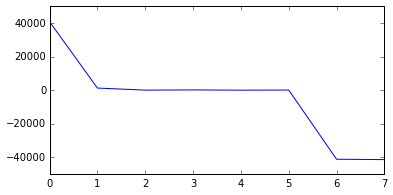

In [35]:
plt.figure(figsize=(6,3))
plt.plot(house_w)
plt.show()

# Problem 2: Derivation of the Bonferroni Correction
Imagine you are playing a dice game with your friends. You roll 2 dice, and to win you must roll two sixes (anything else is a loss). You are a cheater and while your friends are not looking, you roll the dice 3 times to increase your chances.

### 2.a) What is the probability of a double 6 in 1 roll?

>**Answer:**

$$1/36$$

### 2.b) What is the probability of getting a double 6 at least once if you roll your dice 3 times?

>**Answer:**

$$1 - (35/36)^3 = 0.0810$$

### 2.c Now, imagine you train a classifier that gets an error rate better than your competitor's error rate. You then test the significance of the results with the bootstrap method. In 1000 samples of your test set errors, 203 samples show an error rate worse than that of your competitor. What is the p-value of the test whose null hypothesis is that your performance is not different than that of your competitor (with alternative hypothesis that you are better)?

>**Answer:**

We need to calculate $P(x \leq 203)$.

In the binomial distribution with $n$ trials and a success probability of $p$:

* $x = 203$, $n = 1000$, and $p = 0.05$
* The mean, $\mu$ = $np$
* The variance is $\sigma^{2} = \mu(1 - p)$
* The standard deviation (standard error) is $\sigma = \sqrt{\sigma^{2}} = \sqrt{\mu(1-p)}$
* Standardize the values of x using the Z-score formula: $z = \dfrac{x - \mu}{\sigma} = \dfrac{x - \mu}{\sqrt{\mu(1-p)}}$
* p-value corresponding to z score is 0.0

### 2.d) You are not satisfied with the result and you try 5 other classification methods. One of them gets a bootstrap p-value of 0.05. Can you assert that your result is "significantly better" than that of your competitor with 5% chance of being wrong (in the sense that we can reject the null hypothesis with risk 0.05)?

> **Answer:**

No. Since we ran 5 tests, our new p-value threshold is 0.01 (=0.05/5). Thus, our p-value of 0.05 does not meet this threshold.

In addition, the p-value is the probability of observing a result equal to or more extreme than what was actually observed, assuming that the null hypothesis (i.e., the results are due to chance) is true. It cannot tell you whether the results of the statistical test are better than your competitor. It is only used for deciding whether to reject the null hypothesis.

### 2.e) Derive the Bonferroni correction, m * p-value, where m is the number of models tried, for small p-values. Hint: the p-value is like the probability of your double six dice.

>**Answer:**

If we assume a 0.05 significance level and conduct 20 tests, the probability of getting at least on significant result that is due to chance is 64% (see below). In order to account for this chance, we must adjust our p-values. Instead of multiplying the p-value by the number of tests, I like to divid the threshold (typically 0.05) by the number of tests in order to get a new threshold in order for my tests to be statistically significant.

$$
\begin{align}
P(\textrm{at least one significant result}) &= 1 - P(\textrm{no significant result}) \\
&= 1 - (0.05)^{20} \\
&= 0.64
\end{align}
$$

### 2.f) We have a classification problem of normal vs. cancer patients using gene expression data. The feature space has d=50,000 features (genes). We use each gene as a very simple classifier: the feature value is used to predict Y (cancer = +1, normal = -1) with the AUC. The p-value in this case can be computed in a closed form (this is called the Wilcoxon-Mann-Whitney test). You find a gene with p-value 0.0001. Is this a significant gene (in the sense that it is predictive of the Y outcome)? How come the Bonferroni correction gives a value greater than 1?

> **Answer:**

If we assume a $\alpha$ of 0.05, given that we performed 50,000 tests, our new threshold for statistical significance is 0.000001 (=0.05/50,000). A p-value 0.0001 is not statistically significant.

# Problem 3: Independence vs. Correlation
### 3.a) Consider the random variables $X$ and $Y \in \mathbb{R}$ with the following conditions.
* $X$ and $Y$ can take values $[-1,0,1]$.
* When $X$ is $0$, $Y$ takes values $1$ and $-1$ with equal probability $(\frac{1}{2})$. When $Y$ is $0$, $X$ takes values $1$ and $-1$ with equal probability $(\frac{1}{2})$.
* $X$ and $Y$ are $0$ with equal probability $(\frac{1}{2})$.

Are $X$ and $Y$ uncorrelated? Are $X$ and $Y$ independent? Prove your assertions. Hint: Graph these points onto the Cartesian Plane. What's each point's joint probability?

>**Answer:**


$P(X|Y) = P(X)$ in order for them to be independent. However, they are not independent because the possible values for one value are dependent on the other. $P(X=0|Y=1) = 0$ while $P(X=0) = \dfrac{1}{2}$.

When X is not equal 0, Y is equal to 0. $E[XY] = E[X]E[Y] = 0$ for $X$ and $Y$ to be uncorrelated. However, in our case $E[XY] = 0$. Given that one of the terms will always be not zero, $X$ and $Y$ are uncorrelated.

### 3.b) Consider three Bernoulli random variables $B_{1}, B_{2}, B_{3}$ which take values $\{0, 1\}$ with equal probability. Lets construct the following random variables $X, Y, Z: X = B_{1} \oplus B_{2}, Y = B_{2} \oplus B_{3}, Z = B_{1} \oplus B_{3}$, where $\oplus$ indicates the XOR operator. Are $X$, $Y$, and $Z$ pairwise independent? Mutually independent? Prove it.

>**Answer:**

The pairwise joint distributions do not equal the product of their respective marginal distributions, so they are not pairewise independent.

$f_{X}(0) \neq f_{Y}(0) \neq f_{Z}(0)$,

$f_{X}(1) \neq f_{Y}(1) \neq f_{Z}(1)$

They are also not mutually independent since $f_{X, Y, Z} (x,y,z) \neq f_{X}(x) \; f_Y(y) \; f_Z(z)$

### 3.c) Why are the questions above relevant to what we are learning in class? (Hint: under what condition is a problem learnable for various models we have learned about?) Describe a dataset upon which we cannot apply the methods learned in class.

>**Answer:**

The dependence between one variable and another in a dataset can prevent us from using various machine learning models for prediction. The data may not have been generated through some natrual process (e.g. composing emails or handwriting digits) and instead be the result of some error through the process of data aggregation. Deterministic values may have been inserted in the data that were not part of the original data.

# Problem 4: Isocontours of Normal Distributions

Let $f(\mu, \Sigma)$ denote the density function of a Gaussian random variable. Plot isocontours of the following functions:

### 4.a) $f(\mu, \Sigma)$, where 
$\mu = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$ and 
$\Sigma = \begin{bmatrix} 2 & 0 \\ 0 & 1 \end{bmatrix}$

> **Answer:**

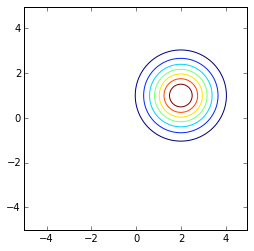

In [36]:
delta = 0.025
x = np.arange(-5, 5, delta)
y = np.arange(-5, 5, delta)
X, Y = np.meshgrid(x, y)
Z = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=1, mux=2, muy=1, sigmaxy=0)
plt.figure(figsize=(4,4))
CS = plt.contour(X, Y, Z)
plt.show()

### 4.b) $f(\mu, \Sigma)$, where 
$\mu = \begin{bmatrix} -1 \\ 2 \end{bmatrix}$ and 
$\Sigma = \begin{bmatrix} 3 & 1 \\ 1 & 2 \end{bmatrix}$

>**Answer:**

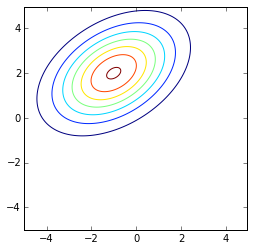

In [37]:
delta = 0.025
x = np.arange(-5, 5, delta)
y = np.arange(-5, 5, delta)
X, Y = np.meshgrid(x, y)
Z = mlab.bivariate_normal(X, Y, sigmax=np.sqrt(3), sigmay=np.sqrt(2), mux=-1, muy=2, sigmaxy=1)
plt.figure(figsize=(4,4))
CS = plt.contour(X, Y, Z)
plt.show()

### 4.c) $f(\mu_{1}, \Sigma_{1}) - f(\mu_{2}, \Sigma_{2})$, where 
$\mu_{1} = \begin{bmatrix} 0 \\ 2 \end{bmatrix}$,
$\mu_{2} = \begin{bmatrix} 2 \\ 0 \end{bmatrix}$, and
$\Sigma_{1} = \Sigma_{2} = \begin{bmatrix} 1 & 1 \\ 1 & 2 \end{bmatrix}$

>**Answer:**

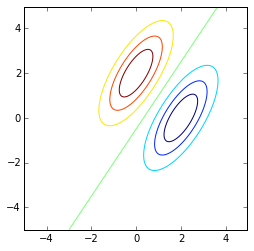

In [38]:
delta = 0.025
x = np.arange(-5, 5, delta)
y = np.arange(-5, 5, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=np.sqrt(2), mux=0, muy=2, sigmaxy=1)
Z2 = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=np.sqrt(2), mux=2, muy=0, sigmaxy=1)
Z = 10.0 * (Z1 - Z2)
plt.figure(figsize=(4,4))
CS = plt.contour(X, Y, Z)
plt.show()

### 4.d) $f(\mu_{1}, \Sigma_{1}) - f(\mu_{2}, \Sigma_{2})$, where 
$\mu_{1} = \begin{bmatrix} 0 \\ 2 \end{bmatrix}$,
$\mu_{2} = \begin{bmatrix} 2 \\ 0 \end{bmatrix}$, and
$\Sigma_{1} = \begin{bmatrix} 1 & 1 \\ 1 & 2 \end{bmatrix}$ and 
$\Sigma_{2} = \begin{bmatrix} 3 & 1 \\ 1 & 2 \end{bmatrix}$

>**Answer:**

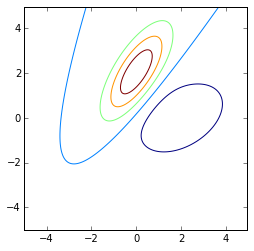

In [39]:
delta = 0.025
x = np.arange(-5, 5, delta)
y = np.arange(-5, 5, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=np.sqrt(2), mux=0, muy=2, sigmaxy=1)
Z2 = mlab.bivariate_normal(X, Y, sigmax=np.sqrt(3), sigmay=np.sqrt(2), mux=2, muy=0, sigmaxy=1)
Z = 10.0 * (Z1 - Z2)
plt.figure(figsize=(4,4))
CS = plt.contour(X, Y, Z)
plt.show()

### 4.e) $f(\mu_{1}, \Sigma_{1}) - f(\mu_{2}, \Sigma_{2})$, where 
$\mu_{1} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$,
$\mu_{2} = \begin{bmatrix} -1 \\ -1 \end{bmatrix}$, and
$\Sigma_{1} = \begin{bmatrix} 1 & 0 \\ 0 & 2 \end{bmatrix}$ and 
$\Sigma_{2} = \begin{bmatrix} 2 & 1 \\ 1 & 2 \end{bmatrix}$

>**Answer:**

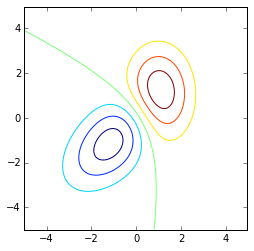

In [40]:
delta = 0.025
x = np.arange(-5, 5, delta)
y = np.arange(-5, 5, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=np.sqrt(2), mux=1, muy=1, sigmaxy=0)
Z2 = mlab.bivariate_normal(X, Y, sigmax=np.sqrt(2), sigmay=np.sqrt(2), mux=-1, muy=-1, sigmaxy=1)
Z = 10.0 * (Z1 - Z2)
plt.figure(figsize=(4,4))
CS = plt.contour(X, Y, Z)
plt.show()

# Problem 5: Visualizing Eigenvectors of Gaussian Covariance Matrix

We have two one dimensional random variables $X_{1} \sim \mathcal{N}(3, 9)$ and $X2 \sim \frac{1}{2}X_{1} + \mathcal{N}(4, 4)$, where $\mathcal{N}(\mu, \sigma^{2})$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^{2}$. In software, draw $N = 100$ random samples of $X_{1}$ and of $X_{2}$.

> **Answer:**

### 5.a) Compute the mean of the sampled data.

In [11]:
X1 = np.random.normal(3, np.sqrt(9), 100)
X2 = 0.5*X1 + np.random.normal(4, np.sqrt(4), 100)

mu_x1 = np.mean(X1)
mu_x2 = np.mean(X2)

print("Mean of X1 =", round(mu_x1,2))
print("Mean of X2 =", round(mu_x2,2))

Mean of X1 = 3.22
Mean of X2 = 5.64


### 5.b) Compute the covariance matrix of the sampled data.

In [12]:
covar_matrix = np.cov(X1, X2)
print(covar_matrix)

[[ 8.49136016  4.49450364]
 [ 4.49450364  6.43882686]]


### 5.c) Compute the eigenvectors and eigenvalues of this covariance matrix.

In [13]:
eig_value, eig_vector = np.linalg.eig(covar_matrix)

print("Eigenvectors\n", eig_vector)
print("Eigenvalues\n",  eig_value)

Eigenvectors
 [[ 0.78185953 -0.62345462]
 [ 0.62345462  0.78185953]]
Eigenvalues
 [ 12.07527639   2.85491063]


### 5.d) On a two dimensional grid with a horizontal axis for $X_{1}$ ranging from $[-15, 15]$ and a vertical axis for X2 ranging from $[-15, 15]$, plot the following:

* All $N = 100$ data points
* Arrows representing both covariance eigenvectors. The eigenvector arrows should originate from the mean and have magnitude equal to their corresponding eigenvalues.

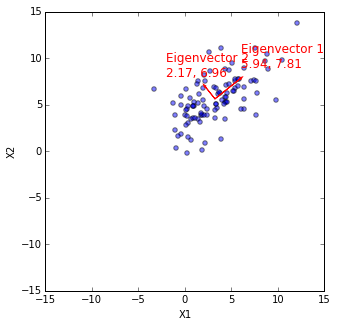

In [43]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X1, X2, alpha=0.5)
ax = plt.axes()
ax.set_aspect('equal')

# 1st eigenvector 1
eig1_x = eig_vector[0,0] * np.sqrt(eig_value[0])  # eigenvectors scaled by sqrt of eignevalues
eig1_y = eig_vector[1,0] * np.sqrt(eig_value[0])
ax.arrow(mu_x1, mu_x2, eig1_x, eig1_y, width=0.01, color='red')
ax.annotate('Eigenvector 1\n{}, {}'.format(round(eig1_x + mu_x1, 2), 
                                           round(eig1_y + mu_x2, 2)),
            xy=(eig1_x, eig1_y), 
            xytext=(6, 9), 
            color='red', 
            size=12)

# 2nd eigenvector
eig2_x = eig_vector[0,1] * np.sqrt(eig_value[1])
eig2_y = eig_vector[1,1] * np.sqrt(eig_value[1])
ax.arrow(mu_x1, mu_x2, eig2_x, eig2_y, width=0.01, color='red')
ax.annotate('Eigenvector 2\n{}, {}'.format(round(eig2_x + mu_x1,2), 
                                           round(eig2_y + mu_x2, 2)), 
            xy=(eig2_x, eig2_y), 
            xytext=(-2, 8), 
            color='red', 
            size=12)

plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### 5.e) By placing the eigenvectors of the covariance matrix into the columns of a matrix $U = [v_{1} \; v_{2}]$, where $v_{1}$ is the eigenvector corresponding to the largest eigenvalue, we can use $U'$ as a rotation matrix to rotate each of our sampled points from our original $(X_{1}, X_{2})$ coordinate system to a coordinate system aligned with the eigenvectors (without the transpose, $U$ can rotate back to the original axes). Center your data points by subtracting the mean and then rotate each point by $U'$, specifcally $x_{rotated} = U'(x - \mu)$. Plot these rotated points on a new two dimensional grid with both axes ranging from $[-15,15]$.

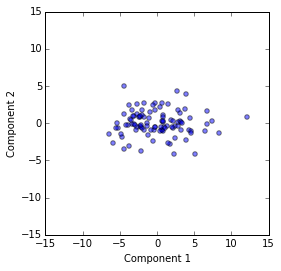

In [42]:
# Center data
X = np.hstack((X1 - mu_x1, X2 - mu_x2))
X.shape = (2, 100)

# Define matrix U
U = eig_vector # eigenvectors already sorted

# Rotate data
X_rotated = U.T.dot(X)

# Plot rotated matrix
fig = plt.figure(figsize=(4, 4))
plt.scatter(X_rotated[0], X_rotated[1], alpha=0.5)
ax = plt.axes()
ax.set_aspect('equal')
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# Problem 6: Covariance Matrixes and Decompositions

As described in lecture, a covariance matrix $\Sigma \in \mathbb{R}^{N, N}$ for a random variable $X \in \mathbb{R}^{N}$ with the following values, where $cov(X_{i}, X_{j}) = E[(X_{i} - \mu_{i})(X_{j} - \mu_{j})]$ is the covariance between the ith and jth elements of the random vector X:

$$
\begin{align}
\Sigma = \left[\begin{array}{ccc}cov(X_{1}, X_{1}) & ... & cov(X_{1}, X_{n}) \\
... &  & ... \\
cov(X_{n}, X_{1}) & ... & cov(X_{n}, X_{n})\end{array}\right] \\
\end{align}
$$


For now, we are going to leave the formal definition of covariance matrices aside and focus instead on some transformations and properties. The motivating example we will use is the N dimensional Multivariate Gaussian Distribution defined as follows:

$$f(x)=\dfrac{1}{\sqrt{(2\pi)^N|\Sigma|}} e^{-\frac{1}{2}({x}-{\mu})^T{\Sigma}^{-1}({x}-{\mu})}$$

### 6.a) We usually assume that $\Sigma^{-1}$ exists, but in many cases it will not. Describe the conditions for which $\Sigma_X^{-1}$ corresponding to random variable X will not exist. Which linear transfer allows us to convert variable X into a new random variable X' (without loss of information), which has an invertible covariance matrix?

**Answer:**

In order to invert $\Sigma$, it must be positive definite ($\forall x \in \mathbb{R}^N, x^T \Sigma x > 0$). If two random variables are dependent on each other or if the n-th random variable is the same value, we won't be able to invert our $\Sigma$. If one of the dependent variables or the n-th variable with the same value is removed, we will be able to invert $\Sigma$.

### 6.b) Consider a data point $x$ drawn from a zero mean Multivariate Gaussian Random Variable $X \in \mathbb{R}^N$ like shown above. Prove that there exists matrix $A \in \mathbb{R}^{N,N}$ such that $x^T \Sigma^{-1} x = \|Ax \|^2_2$ for all vectors $x$. What is the matrix $A$?

**Answer:**

$$
\begin{align}
x^T \Sigma^{-1} x &= \|Ax \|^2_2 \\
x^T \Sigma^{-1} x &= (Ax)^T Ax = x^T A^T Ax \\
\Sigma^{-1} & = A^T A \\
(U S^2 U^T)^{-1} &= A^T A \\
(U S^{-1}) (S^{-1} U^T) &= A^T A \\
S^{-1} U^{T} &= A \\
\end{align}
$$

### 6.c) In the context of Multivariate Gaussians from the previous problem, what is the intuitive meaning of $x^T \Sigma^{-1} x$ when we transform it into $\|Ax \|^2_2$?

**Asnwer:**

When transformed into $\|Ax \|^2_2$, $x^T \Sigma^{-1}x$ is the sqaured L2 norm of $Ax$. This is essentially a distance measure from the mean.

### 6.d) Let's constrain $\|x\|_2 = 1$. In other words, the L2 norm (or magnitude) of vector $x$ is 1. In this case, what is the maximum and minimum value of $\|Ax \|^2_2$? If we have $X_i \perp X_j \forall i, j$, then what is the intuitive meaning for the maximum and minimum value of  $\|Ax \|^2_2$? To maximize the probability of $f(x)$, which x should we choose?

**Answer:**



A 1 in the position of the largest eigenvalue and 0's everywhere else would give us the maximum value. If we place a 1 in the position of the smallest eigenvalue and 0's everywhere else, we'll get the minimum value.

The intuitive meaning of the maximum value of $\|Ax\|_2^2$ is the lowest probability of a value belonging to a particular class. The minimum value of $\|Ax\|_2^2$ corresponds to the greatest probability.

To maximize the probability of $f(x)$, we should choose the value of x that minimized $\|Ax\|^2_2$ given our $\|x\|_2 = 1$.

## Problem 7: Gaussian Classifiers for Digits

In this problem we will build Gaussian classifiers for digits in MNIST. More specifically, we will model each digit class as a Gaussian distribution and make our decisions on the basis of posterior probabilities. This is a generative method for classifying images where we are modelling the class conditional probabilities as normal distributions. The steps mentioned below should be done for each training set in train.mat and you need to plot a curve of error rate vs no. of training examples upon evaluating on the test set in test.mat. Submit your trained labels for the kaggle.mat dataset on the Kaggle competition website. Please use do not use the datasets that we provided in the HW1.zip folder, and only use the datasets provided in the current HW3.zip folder. We have randomized the MNIST test and training sets.

### 7.a) Taking raw pixel values as features, fit a Gaussian distribution to each digit class using maximum likelihood estimation. This involves finding the means and covariance matrices for each digit class. Say we have i.i.d observations $X_{1}...X_{n}$, what are the maximum likelihood estimates for the mean and covariance matrix of a Gaussian distribution? Are these estimators unbiased? (No need to prove for covariance)

Tip: It is a good idea to contrast normalize images before using the raw pixel values. One way of normalization is to divide the pixel values of an image by the l2 norm of its pixel values.

**Answer:**

The PDF for a likelihood for a normal distribution is defined by:

$$f_{\mathbf x}(x_1,\ldots,x_k) =\dfrac{1}{\sqrt{(2\pi)^{k}|\Sigma|}}\exp\left(-\frac{1}{2}({\mathbf x}-{\mu})^\mathrm{T}{\Sigma}^{-1}({\mathbf x}-{\mu})\right)$$

Take log:

$$\log f(X | \mu, \Sigma) = -\frac{n}{2} \log (|\Sigma|\,)- \dfrac{1}{2} \sum^n_{i=1} (x_i - \mu)^T \Sigma^{-1} (x_i - \mu)$$

Take derivative with respect to $\mu$ and set equal to 0:

$$
\begin{align}
\dfrac{\partial}{\partial \mu} \log f(X|\mu,\Sigma) &= \dfrac{\partial}{\partial \mu} -\dfrac{1}{2} \sum_{i=1}^n (x_i - \mu)\Sigma^{-1}(x_i - \mu) \\
&= \dfrac{\partial}{\partial \mu} -\dfrac{1}{2} \sum_{i=1}^n x_i^T \Sigma^{-1} x_i - x_i^T \Sigma^{-1} \mu - \mu^T \Sigma^{-1} x_i + \mu^T \Sigma^{-1} \mu \\
&= \dfrac{\partial}{\partial \mu} -\dfrac{1}{2} \sum_{i=1}^n - x_i^T \Sigma^{-1} \mu - \mu^T \Sigma^{-1} x_i + \mu^T \Sigma^{-1} \mu \\
&= \dfrac{\partial}{\partial \mu} -\dfrac{1}{2} \sum_{i=1}^n - 2(\mu^T \Sigma^{-1} x_i) + \mu^T \Sigma^{-1} \mu \\
&= \dfrac{\partial}{\partial \mu} -\dfrac{n}{2} (\mu^T \Sigma^{-1} \mu) + \dfrac{2}{2} \sum_{i=1}^n \mu^T \Sigma^{-1} x_i \\
&= -\dfrac{n}{2} (\Sigma^{-1} + (\Sigma^{-1})^T) \mu + \dfrac{\partial}{\partial \mu} \sum_{i=1}^n \mu^T \Sigma^{-1} x_i \\
&= -n \Sigma^{-1} \mu + \Sigma^{-1} \sum_{i=1}^n x_i\\
\hat\mu &= \dfrac{1}{n} \sum^n_{i=1} x_i \\
\end{align}
$$

This is the maximum of the function. The MLE for the mean is unbiased because its expectation value is equal to the parameter $\mu$:

$$E \left[ \hat\mu \right] = \mu$$

The MLE of the covariance matrix is: 

$$
\begin{align}
\dfrac{\partial}{\partial \Sigma} \log f(X | \mu, \Sigma) &= -\frac{1}{2} \left( \frac{ \partial \log(|{\Sigma}|)}{\partial{\Sigma}} + \sum_{i=1}^n \frac{\partial \left( x_i - {\mu}\right)^T {\Sigma}^{-1} \left( x_i - {\mu}\right) }{\partial {\Sigma}} \right)\\
&= -\frac{1}{2} \left( {\Sigma}^{-1} + \sum_{i=1}^n \left(x_i - {\mu} \right) \left(x_i - {\mu} \right)^T \right) \\
\hat\Sigma &= \dfrac{1}{n}\sum_{i=1}^n (x_i - \mu)(x_i - \mu)^T
\end{align}
$$

The MLE for the covariance is biased, given

$$E \left[ \hat\Sigma \right] = \dfrac{n - 1}{n} \Sigma$$

### 7.b) How would you model the prior distribution for each class? Compute prior probabilities for all classes.

**Answer:**

You can calculate the priors for each class by calculating their frequencies in the data.

In [16]:
digit = scipy.io.loadmat('./data/train.mat')
digit_y = digit['train_labels']
digit_n = digit_y.shape[0]
digit_X = digit['train_images'].T.reshape(digit_n, 28*28)

digit_yX = np.hstack((digit_y, digit_X))
np.random.shuffle(digit_yX)

digit_test_y, digit_test_X = digit_yX[:10000,0], digit_yX[:10000,1:]
digit_train_y, digit_train_X = digit_yX[10000:,0], digit_yX[10000:,1:]

priors = np.bincount(digit_train_y)
list(zip(range(10), priors/digit_train_y.shape[0]))

[(0, 0.097680000000000003),
 (1, 0.11394),
 (2, 0.099440000000000001),
 (3, 0.10181999999999999),
 (4, 0.097739999999999994),
 (5, 0.090440000000000006),
 (6, 0.09844),
 (7, 0.10366),
 (8, 0.0969),
 (9, 0.099940000000000001)]

### 7.c) Visualize the covariance matrix for a particular class. Do you see any kind of structure in the matrix? What does this symbolize?

**Answer:**

The covariance matrix has a diagonal structure.

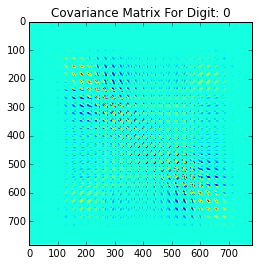

In [44]:
def plot_covar_matrix(X, y, digit):
    X = X[y == digit].T
    cov_mat = np.cov(X)
    plt.figure(figsize=(4, 4))
    plt.imshow(cov_mat, interpolation='none')
    plt.title('Covariance Matrix For Digit: {}'.format(digit), fontsize=12)
    plt.show()

plot_covar_matrix(digit_train_X, digit_train_y, 0)

# 7.d) We will now classify digits in the test set on the basis of posterior probabilities using two different approaches:

#### 7.d.i) Define $\Sigma_{overall}$ to be the average of the covariance matrices of all the classes. We will use this matrix as an estimate of the covariance of all the classes. This amounts to modelling class conditionals as Gaussians $(\sim \mathcal{N}(\mu_{i}, \Sigma_{overall}))$ with different means and the same covariance matrix. Using this form of class conditional probabilities, classify the images in the test set into one of the 10 classes assuming $0-1$ loss and compute the error rate and plot it over the following number of randomly chosen training data points $[100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]$. Expect some variance in your error rate for low training data scenarios. What is the form of the decision boundary in this case? Why?

**Answer:**

The decision boundary is linear since each digit class draws from a distribution with the same covariance matrix.

In [18]:
def sigma_overall(X, y, alpha, labels):
    X_mu_all = []
    for i in labels:
        X_i = X[y == i]
        X_mu_all.append(np.mean(X_i, axis=0))
    X_covar_all = np.cov(X.T)
    np.fill_diagonal(X_covar_all, X_covar_all.diagonal() + alpha)
    return np.array(X_mu_all), X_covar_all


def score_overall(X, mu, cov, labels):
    pred_list = []
    for i in labels:
        multivariate_fx = multivariate_normal(mean=mu[i], cov=cov)
        logpdf = multivariate_fx.logpdf(X)
        pred_list.append(logpdf)
    y_hat = np.argmax(np.array(pred_list), axis=0)
    return y_hat


def train_gaussian_overall(train_X, train_y, test_X, test_y, sample_sizes, alpha, labels):
    error_rates = []
    for s in sample_sizes:
        mu_all, covar_all = sigma_overall(train_X[:s,:], train_y[:s], alpha, labels)
        y_hat = score_overall(test_X, mu_all, covar_all, labels)
        correct = np.sum(test_y == y_hat)
        n = test_y.shape[0]
        error_rate = 1 - (correct/n)
        error_rates.append((s, error_rate))
    return error_rates

In [19]:
sample_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]

overall_error = train_gaussian_overall(digit_train_X/255,
                                       digit_train_y, 
                                       digit_test_X/255,
                                       digit_test_y, 
                                       sample_sizes,
                                       alpha=0.001,
                                       labels=np.arange(10))

for x in overall_error:
    print("{:<7}{:<7}".format(x[0], round(x[1],3)))

100    0.501  
200    0.486  
500    0.418  
1000   0.335  
2000   0.264  
5000   0.221  
10000  0.202  
30000  0.191  
50000  0.188  


#### 7.d.ii) We can also model class conditionals as $\mathcal{N}(\mu_{i}, \Sigma_{i})$, where $\Sigma_{i}$ is the estimated covariance matrix for the $i^{th}$ class. Classify images in the test set using this form of the conditional probability (assuming $0-1$ loss) and compute the error rate and plot it over the following number of randomly chosen training data points $[100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]$. What is the form of the decision boundary in this case?

**Answer:**

The decision boundary form is quadratic. This is because each class is from a distribution with a different covariance matrix; the shape of the gaussian is different for each class.

In [20]:
def sigma_indiv(X, y, alpha, labels):
    mu_indiv = []
    covar_indiv = []
    for i in labels:
        X_i = X[y == i]
        mu_indiv.append(np.mean(X_i, axis=0))
        covar = np.cov(X_i.T)
        np.fill_diagonal(covar, covar.diagonal() + alpha)
        covar_indiv.append(covar)
    return np.array(mu_indiv), np.array(covar_indiv)


def score_indiv(X, mu_indiv, covar_indiv, labels):
    pred_list = []
    for i in labels:
        multivariate_fx = multivariate_normal(mean=mu_indiv[i], cov=covar_indiv[i])
        logpdf = multivariate_fx.logpdf(X)
        pred_list.append(logpdf)
    y_hat = np.argmax(np.array(pred_list), axis=0)
    return y_hat

    
def train_gaussian_indiv(train_X, train_y, test_X, test_y, sample_sizes, alpha, labels):
    error_rates = []
    for s in sample_sizes:
        mu_indiv, covar_indiv = sigma_indiv(train_X[:s], train_y[:s], alpha, labels)
        y_hat = score_indiv(test_X, mu_indiv, covar_indiv, labels)
        correct = np.sum(test_y == y_hat)
        n = test_y.shape[0]
        error_rate = 1 - (correct/n)
        error_rates.append((s, error_rate))
    return error_rates

In [21]:
indiv_error = train_gaussian_indiv(digit_train_X/255,
                                   digit_train_y, 
                                   digit_test_X/255,
                                   digit_test_y, 
                                   sample_sizes,
                                   alpha=0.001,
                                   labels=np.arange(10))

for x in indiv_error:
    print("{:<7}{:<7}".format(x[0], round(x[1],3)))

100    0.359  
200    0.25   
500    0.148  
1000   0.154  
2000   0.126  
5000   0.127  
10000  0.121  
30000  0.123  
50000  0.12   


#### 7.d.iii) Compare your results in parts (i) and (ii). What do you think is the source of difference in the performance?

**Answer:**

$\Sigma_{i}$ far out performed $\Sigma_{overall}$ across all training sample sizes. Class-specific covariance matrices lead to better performance than an overall covariance matrix because it is more representative of the underlying data for each class.

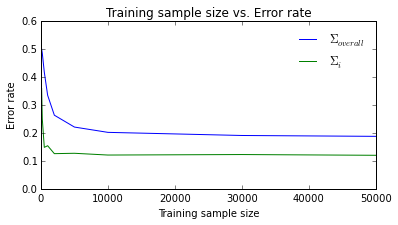

In [47]:
_, overall_err = zip(*overall_error)
_, indiv_err   = zip(*indiv_error)

plt.figure(figsize=(6, 3))
plt.plot(sample_sizes, overall_err, label='$\Sigma_{overall}$')
plt.plot(sample_sizes, indiv_err,   label='$\Sigma_{i}$')
plt.ylim(0,0.6)
plt.ylabel('Error rate')
plt.xlabel('Training sample size')
plt.title('Training sample size vs. Error rate')
plt.legend(loc=1, frameon=False)
plt.show()

#### 7.d.iv) Train your best classifier using train.mat and classify the images in kaggle.mat. Submit your labels to the online Kaggle competition and record your optimum prediction rate. If you used an additional featurizer, please describe your implementation. Please only use any extra "image featurizer" code on this portion of the assignment.

Note: In your submission, you need to include learning curves (error-rate vs no. of training examples) and actual error-rate values for the above two cases and short explanations for the all the questions. Also, the covariance matrices you compute using MLE might be singular (and thus non-invertible). In order to make them non-singular and positive definite, you can add a small weight to their diagonals by setting $\Sigma_{i} = \Sigma_{i} + \alpha I$, where $\alpha$ is the weight you want to add to the diagonals. You may want to use k-fold cross validation to see what the optimum "small weight" is.

**Answer:**

I achieved a 12.38% error rate on Kaggle. For normalization, I divided the pixel values by 255 and added an $\alpha$ of $.001$ to my diagonals. No additional featurizer was used in my Kaggle submission. My training and test set performance vs training data size is plotted above.

In [23]:
digit_kaggle = scipy.io.loadmat('./data/test.mat')
digit_kaggle_test_X = digit_kaggle['test_images']

def kaggle_gaussian_indiv(train_X, train_y, test_X, sample_size, alpha, labels):
    mu_indiv, covar_indiv = sigma_indiv(train_X[:sample_size], train_y[:sample_size], alpha, labels)
    y_hat = score_indiv(test_X, mu_indiv, covar_indiv, labels)
    return y_hat

In [24]:
digit_kaggle_pred = kaggle_gaussian_indiv(digit_X/255, 
                                          digit_y.reshape(digit_n), 
                                          digit_kaggle_test_X/255, 
                                          sample_size=60000, 
                                          alpha=0.001, 
                                          labels=np.arange(10))

# For submitting to Kaggle
# digit_kaggle_submit = np.vstack((np.arange(1,len(digit_kaggle_pred)+1), digit_kaggle_pred)).T
# np.savetxt(fname="./digit_prediction.csv", X=digit_kaggle_submit, fmt='%d', delimiter=',', header='Id,Category', comments='')

#### 7.e) Now that you have developed Gaussian classification for digits, lets apply this to spam. Use the training and testing data located in spam_dataset.mat to generate a set of test labels that you will submit to the online Kaggle competition and record your optimum prediction rate. If you used an additional featurizer, please describe your implementation.

Optional: If you use the default feature set, you may obtain relatively low classification rates. The TA's suggest using a bag of words model. You may download 3rd party packages if you wish. Also, normalizing your vectors like before may help.

**Answer:**

I used TF-IDF for feature engineering and used an $\alpha$ of 0.001. I was able to acheive a 25.1% error rate on Kaggle.

In [25]:
spam_kaggle = scipy.io.loadmat('./data/spam_data.mat')
spam_train_X = spam_kaggle['training_data']
spam_train_y = spam_kaggle['training_labels'][0]
spam_test_X  = spam_kaggle['test_data']

# Feature engineering
tf = TfidfTransformer()
spam_tfidf_train_X = tf.fit_transform(spam_train_X, spam_train_y).toarray()
spam_tfidf_test_X  = tf.transform(spam_test_X).toarray()

def sigma_spam_indiv(X, y, alpha, labels):
    X_covar = {}
    X_mu = {}
    for i in labels:
        X_i = X[y == i]
        X_mu[i] = np.mean(X_i, axis=0)
        X_cov = np.cov(X_i.T)
        np.fill_diagonal(X_cov, X_cov.diagonal() + alpha)
        X_covar[i] = X_cov
    return X_mu, X_covar


def score_spam_indiv(X, mu_dict, cov_dict, labels):
    pred = {}
    for i in labels:
        multivariate_fx = multivariate_normal(mean=mu_dict[i], cov=cov_dict[i])
        pred[i] = multivariate_fx.logpdf(X)
    return np.where(pred[0] > pred[1], 0, 1)


def train_spam_indiv(train_X, train_y, test_X, alpha, labels):
    list_error = []
    mu_matrix, cov_matrix = sigma_spam_indiv(train_X, train_y, alpha, labels)
    pred_labels = score_spam_indiv(test_X, mu_matrix, cov_matrix, labels)
    return pred_labels

In [26]:
spam_kaggle_pred = train_spam_indiv(spam_tfidf_train_X, spam_train_y, 
                                    spam_tfidf_test_X, alpha=0.001,
                                    labels=[0,1])

# For submitting to Kaggle
# spam_kaggle_submit = np.vstack((np.arange(1,len(spam_kaggle_pred)+1), spam_kaggle_pred)).T
# np.savetxt(fname="./spam_tfidf_prediction.csv", X=spam_kaggle_submit, fmt='%d', delimiter=',', header='Id,Category', comments='')